In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.encodings import *
from utils.statistics import calculate_statistics, calculate_fid, ssim
from utils.haar_noising_script import apply_global_haar_scrambling
from utils.quantum_diffusion import *

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

import pennylane as qml

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


In [2]:
QG_channel = 1
filename = f"data/QG{QG_channel}_64x64_1k"
num_samples = 10
seed = 42
n_qubits = 12
results_file = f"data/QG{QG_channel}_results.csv"

data_X = np.array(h5py.File(filename, "r")['X'])
print("Data shape:", data_X.shape)

Data shape: (1000, 64, 64)


In [ ]:
# Do not run this unless needing to reencode and rescramble everything
encoding_methods = {
    "angle": angle_encoding,
    "amplitude": amplitude_encoding,
    "sinusoidal": sinusoidal_encoding,
    "iqp": iqp_encoding,
}

def encode_dataset(encoding_fn, data, num_samples, n_qubits):
    """Encode all samples using a given encoding function."""
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit(image):
        encoding_fn(image, wires=range(n_qubits))
        return qml.state()

    encoded = [circuit(data[i]) for i in range(num_samples)]
    return np.array(encoded)

# Loop through all encodings
for name, enc_fn in encoding_methods.items():
    print(f"\n=== Running with {name} encoding ===")
    
    if enc_fn == "angle":
        n_qubits = 4096
    
    encoded_data = encode_dataset(enc_fn, data_X, num_samples, n_qubits)
    # encoded_data_torch = torch.tensor(encoded_data, dtype=torch.float32)
    
    scrambled_states, used_unitaries = apply_global_haar_scrambling(np.array(encoded_data), seed=42, approx_threshold_qubits=200)
    scrambled_torch = torch.tensor(scrambled_states, dtype=torch.float32)

    torch.save(torch.tensor(encoded_data, dtype=torch.float32), f"data/QG{QG_channel}_64x64_{num_samples}_{name}_encoded.pt")
    torch.save(scrambled_torch, f"data/QG{QG_channel}_64x64_{num_samples}_{name}_scrambled.pt")


Data shape: (1000, 64, 64)

=== Running with angle encoding ===

=== Running with amplitude encoding ===

=== Running with sinusoidal encoding ===

=== Running with iqp encoding ===


In [ ]:
import pandas as pd

encodings = ["angle", "amplitude", "sinusoidal", "iqp"]
results = []
results_file = f"data/QG{QG_channel}_results.csv"

for enc in encodings:
    print(f"\n=== {enc} encoding ===")
    encoded = torch.load(f"data/QG{QG_channel}_64x64_{num_samples}_{enc}_encoded.pt")
    scrambled = torch.load(f"data/QG{QG_channel}_64x64_{num_samples}_{enc}_scrambled.pt")
    print("Loaded encoded and scrambled data.")

    train_enc, val_enc, train_scr, val_scr = train_test_split(
        encoded, scrambled, test_size=0.2, random_state=42, shuffle=True
    )

    model, reconstructed, _, _ = train_model(train_enc, val_enc, train_scr, val_scr, num_epochs=5)

    # Metrics
    mu_real, sigma_real = calculate_statistics(data_X[:len(reconstructed)])
    mu_fake, sigma_fake = calculate_statistics(reconstructed)
    fid = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    mean_ssim = calculate_ssim(data_X, reconstructed)

    results.append({"encoding": enc, "FID": fid, "SSIM": mean_ssim})

    pd.DataFrame(results).to_csv(results_file, index=False)
    print(f"Saved partial results to {results_file}")

print("\n=== Final Results ===")
results_df = pd.DataFrame(results)
print(results_df)



=== angle encoding ===
Loaded encoded and scrambled data.


C:\Users\realc\AppData\Local\Temp\ipykernel_10080\790303252.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded = torch.load(f"data/QG{QG_channel}_64x64_{num_samples

Epoch [1/5] - Loss: 0.0047, Val Loss: 0.0025
Epoch [2/5] - Loss: 0.0025, Val Loss: 0.0011
Epoch [3/5] - Loss: 0.0011, Val Loss: 0.0005
Epoch [4/5] - Loss: 0.0005, Val Loss: 0.0004
Epoch [5/5] - Loss: 0.0004, Val Loss: 0.0005
Saved partial results to data/QG1_results.csv

=== amplitude encoding ===
Loaded encoded and scrambled data.
Epoch [1/5] - Loss: 0.0032, Val Loss: 0.0011


C:\Users\realc\AppData\Local\Temp\ipykernel_6436\2107443508.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\realc

Loaded amplitude model from saved_models/QG1_amplitude_model.pt
Loaded model for amplitude encoding.

=== Evaluation for amplitude encoding ===
FID : 4107.7844
SSIM: -0.0000


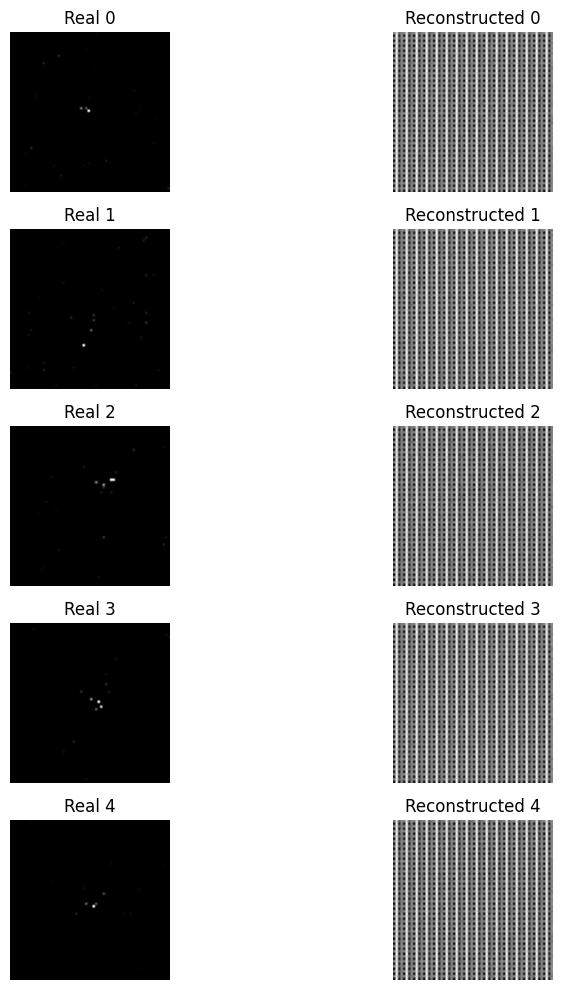

In [11]:
n_layers = 8
input_dim = 32 * 32 * 4
hidden_dim = 128
output_dim = input_dim  
dim = 32
n_qubits = 8

def load_trained_model(enc, model_dir="saved_models"):
    """Reload a trained model for the given encoding name."""
    model_path = f"{model_dir}/QG{QG_channel}_{enc}_model.pt"
    model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Loaded {enc} model from {model_path}")
    return model

def reconstruct_images(model, scrambled, n_show=5):
    """Run model on scrambled states and plot reconstructions vs real images."""
    model.eval()
    with torch.no_grad():
        denoised = model(scrambled.view(len(scrambled), -1))
        denoised = denoised.view(len(scrambled), 32, 32, 4).detach().numpy()
        decoded = flip(decode(denoised))  # back to (N, 64, 64)

    # Visualize first n_show samples
    plt.figure(figsize=(10, 2*n_show))
    for i in range(n_show):
        plt.subplot(n_show, 2, 2*i+1)
        plt.imshow(data_X[i], cmap="gray")
        plt.title(f"Real {i}")
        plt.axis("off")

        plt.subplot(n_show, 2, 2*i+2)
        plt.imshow(decoded[i], cmap="gray")
        plt.title(f"Reconstructed {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    return decoded

def evaluate_on_unseen(enc, num_test=20):
    """Reconstruct unseen scrambled images and evaluate FID + SSIM."""
    # Load trained model
    model = load_trained_model(enc)
    print(f"Loaded model for {enc} encoding.")

    # Load encoded & scrambled data
    encoded = torch.load(f"data/QG{QG_channel}_64x64_{num_samples}_{enc}_encoded.pt")
    scrambled = torch.load(f"data/QG{QG_channel}_64x64_{num_samples}_{enc}_scrambled.pt")

    # Take last `num_test` samples as unseen test set
    test_enc = encoded[-num_test:]
    test_scr = scrambled[-num_test:]
    real_images = data_X[-num_test:]

    # Reconstruct
    model.eval()
    with torch.no_grad():
        denoised = model(test_scr.view(len(test_scr), -1))
        denoised = denoised.view(len(test_scr), 32, 32, 4).detach().numpy()
        reconstructed = flip(decode(denoised))  # (num_test, 64, 64)

    # Compute metrics
    mu_real, sigma_real = calculate_statistics(real_images)
    mu_fake, sigma_fake = calculate_statistics(reconstructed)
    fid = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    mean_ssim = calculate_ssim(real_images, reconstructed)

    print(f"\n=== Evaluation for {enc} encoding ===")
    print(f"FID : {fid:.4f}")
    print(f"SSIM: {mean_ssim:.4f}")

    n_show = min(5, num_test)
    plt.figure(figsize=(10, 2*n_show))
    for i in range(n_show):
        plt.subplot(n_show, 2, 2*i+1)
        plt.imshow(real_images[i], cmap="gray")
        plt.title(f"Real {i}")
        plt.axis("off")

        plt.subplot(n_show, 2, 2*i+2)
        plt.imshow(reconstructed[i], cmap="gray")
        plt.title(f"Reconstructed {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    return fid, mean_ssim, reconstructed


fid, ssim_score, recon_images = evaluate_on_unseen("amplitude", num_test=10)
